# Moving Average


通过将长期均值与短期均值相比，求出相应的价差，通过价差预测基础趋势、入手时机

原理：
1. 同一个品种不可能存在较大差异，自然回归均值
2. 长周期包含中周期，中周期包含短周期，长期看位置，中期综合评估，短期看是大于0还是小于0
3. 大盘向上或者向下辅助决策相应的品种选择
4. 起始点位置决定后续的方向，起始点不能大幅波动
5. 预测周期是确定的，不能改变，预测周期作用于起始点位置



## 步骤1：提取数据

关键点是设置长期的时间，如果过长，则迟迟不回归投资机会少，如果过短，则长期记忆丢失

设置短：投资机会多，但是相应的规则要更加严格

设置长：投资机会少，但是相对稳健，投资规则可以宽泛一点

判断依据：周期内是否有一个完整的波峰波谷

In [356]:
import numpy as np
import pandas as pd

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')

In [357]:
# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [358]:
# 使用ETF进行研究
# 510050：上证50ETF
# 159919：沪深300ETF
# 510500：中证500
# 512100：中证1000
# 159915：易方达创业板指数

# ETF是一揽子股票，没有相应组成部分，只能从字面上理解相应的组成，通过指数来进行模拟

candidate_ETF = [
    "510050.XSHG",
    "159919.XSHE",
    "510500.XSHG",
    "512100.XSHG",
    "159915.XSHE"
]


# 确定整体时间长度，默认设置为过去500天
ncount = 2000

# 确定end_date
end_date='2025-2-28'

In [359]:
# 生成价格pandas数组
price_pd = pd.DataFrame()


for ETF_i in candidate_ETF:
    
    # 初始变量命名
    ETF_i_name = ""
    ETF_i_name = str(ETF_i[:6]) + "_ETF"
    
    # 显示过程
    print(ETF_i_name)

    # 提取价格数据
    price_ETF_temp = pd.DataFrame()
    price_ETF_temp = get_price(ETF_i, count = ncount, end_date=end_date, frequency='daily',fq='pre', fields=['close'])['close']
    price_ETF_temp.name = ETF_i_name
    
    # 数据合并
    price_pd = pd.concat([price_pd,price_ETF_temp], axis = 1)


510050_ETF
159919_ETF
510500_ETF
512100_ETF
159915_ETF


In [360]:
price_pd.head()

,510050_ETF,159919_ETF,510500_ETF,512100_ETF,159915_ETF
2016-12-02,2.118,3.235,5.767,2.709,2.055
2016-12-05,2.080,3.171,5.729,2.693,2.055
2016-12-06,2.076,3.159,5.736,2.674,2.036
2016-12-07,2.082,3.174,5.805,2.704,2.044
2016-12-08,2.086,3.170,5.776,2.679,2.028


## 步骤2：数据处理

通过不同周期的收益率，计算收益率的利差

In [361]:
# 使用ETF进行研究
# 510050：上证50ETF
# 159919：沪深300ETF
# 510500：中证500
# 512100：中证1000
# 159915：易方达创业板指数

# 确定基准（short方），投资（long方）
benchmark_etf = price_pd['510500_ETF']
invest_etf = price_pd['510050_ETF']


# 确定周期
# 5日是基准调仓周期
# 30日是
period_long = 100
period_medium = 20
period_short = 5 

Spread_pd = pd.concat([benchmark_etf,invest_etf], axis =1)

Spread_pd.columns = ['benchmark_etf', 'invest_etf']

In [362]:
# 计算收益率
Spread_pd['yield_bench'] = Spread_pd['benchmark_etf']/Spread_pd['benchmark_etf'].shift(1)
Spread_pd['yield_invest'] = Spread_pd['invest_etf']/Spread_pd['invest_etf'].shift(1)

In [363]:
# 计算收益率之差
Spread_pd['yield_spread'] = Spread_pd['yield_invest'] - Spread_pd['yield_bench']



In [364]:
# 计算不同周期的累计收益率
Spread_pd['yield_spread'] = Spread_pd['yield_invest'] - Spread_pd['yield_bench']

Spread_pd['yield_spread_short'] = (1 + Spread_pd['yield_spread']).\
                                    rolling(window=period_short).apply(np.prod, raw=True) - 1
    
Spread_pd['yield_spread_medium'] = (1 + Spread_pd['yield_spread']).\
                                    rolling(window=period_medium).apply(np.prod, raw=True) - 1
    
Spread_pd['yield_spread_long'] = (1 + Spread_pd['yield_spread']).\
                                    rolling(window=period_long).apply(np.prod, raw=True) - 1

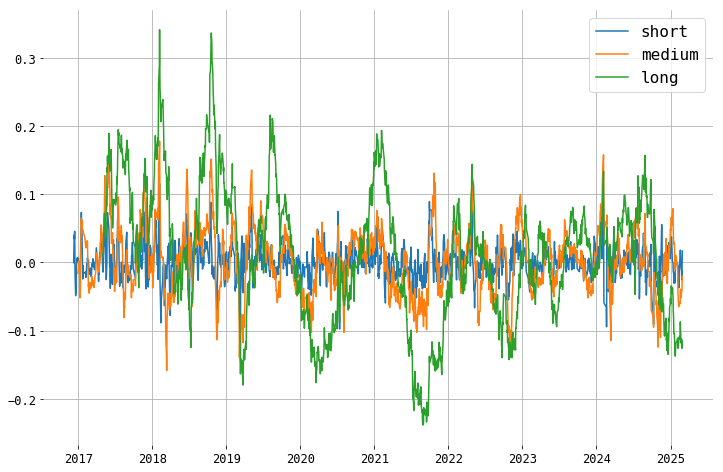

In [365]:
# Plot
plt.plot(Spread_pd.index,Spread_pd['yield_spread_short'] )

plt.plot(Spread_pd.index,Spread_pd['yield_spread_medium'] )

plt.plot(Spread_pd.index,Spread_pd['yield_spread_long'] )

plt.legend(['short', 'medium','long']);


## 步骤3：验证

条件：
1. 同一个品种不可能存在较大差异，自然回归均值
2. 长周期包含中周期，中周期包含短周期，长期看位置，中期综合评估，短期看是大于0还是小于0
3. 大盘向上或者向下辅助决策相应的品种选择
4. 起始点位置决定后续的方向，起始点不能大幅波动
5. 预测周期是确定的，不能改变，预测周期作用于起始点位置

### 条件1：回归均值
### 条件2：短期带动长期变化

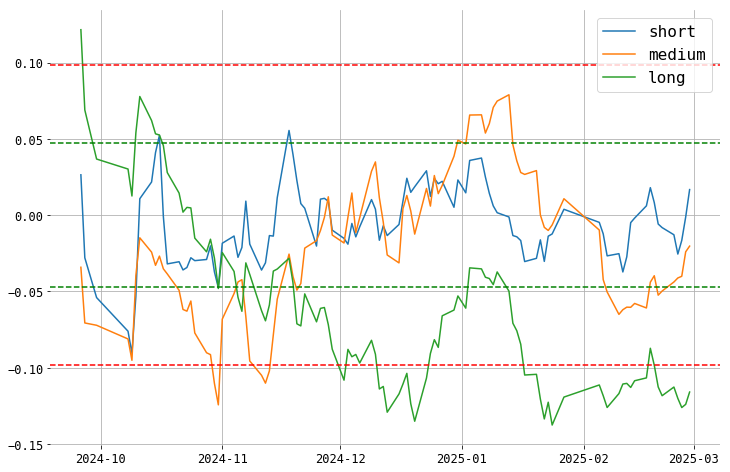

In [375]:
# 画出最后一段时间的线
plt.plot(Spread_pd.index[-100:],Spread_pd['yield_spread_short'][-100:] )
plt.plot(Spread_pd.index[-100:],Spread_pd['yield_spread_medium'][-100:] )
plt.plot(Spread_pd.index[-100:],Spread_pd['yield_spread_long'][-100:] )


# 画出长期均线
plt.axhline(Spread_pd['yield_spread_long'].std(), color='red', linestyle='--')
plt.axhline(-Spread_pd['yield_spread_long'].std(), color='red', linestyle='--')


# 画出中期均线
plt.axhline(Spread_pd['yield_spread_medium'].std(), color='green', linestyle='--')
plt.axhline(-Spread_pd['yield_spread_medium'].std(), color='green', linestyle='--')


plt.legend(['short', 'medium','long']);


In [367]:
Spread_pd['yield_spread_long'][-100:]

2024-09-26    0.121495
2024-09-27    0.068885
2024-09-30    0.036760
2024-10-08    0.030217
2024-10-09    0.012554
2024-10-10    0.053941
2024-10-11    0.077729
2024-10-14    0.061994
2024-10-15    0.053280
2024-10-16    0.052504
2024-10-17    0.045589
2024-10-18    0.027904
2024-10-21    0.014478
2024-10-22    0.001988
2024-10-23    0.005097
2024-10-24    0.004745
2024-10-25   -0.015017
2024-10-28   -0.024003
2024-10-29   -0.015767
2024-10-30   -0.028088
2024-10-31   -0.048054
2024-11-01   -0.024479
2024-11-04   -0.036856
2024-11-05   -0.053747
2024-11-06   -0.062970
2024-11-07   -0.031256
2024-11-08   -0.038831
2024-11-11   -0.062558
2024-11-12   -0.069202
2024-11-13   -0.058816
                ...   
2025-01-10   -0.037186
2025-01-13   -0.049770
2025-01-14   -0.070794
2025-01-15   -0.075730
2025-01-16   -0.084542
2025-01-17   -0.104707
2025-01-20   -0.104256
2025-01-21   -0.120493
2025-01-22   -0.133473
2025-01-23   -0.122533
2025-01-24   -0.137475
2025-01-27   -0.119167
2025-02-05 

### 条件3：大盘变化趋势

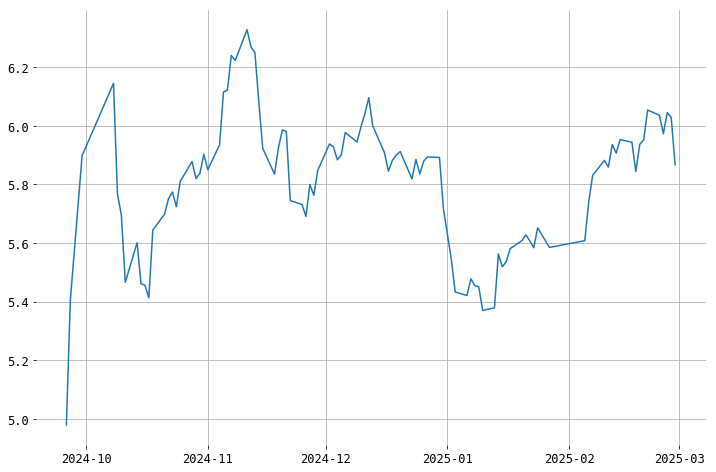

In [368]:
plot(benchmark_etf[-100:])

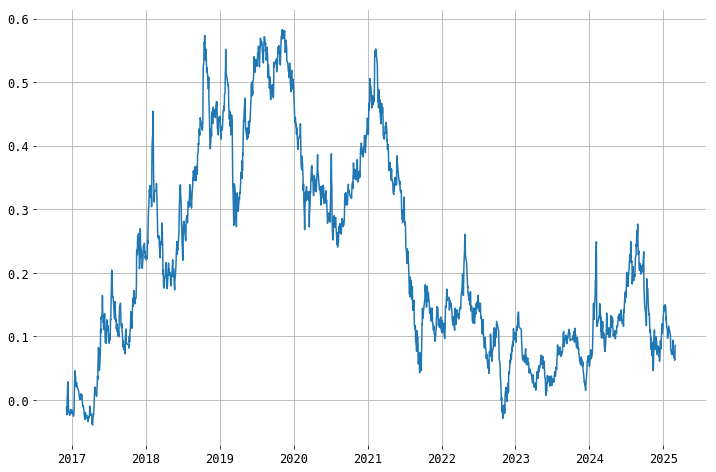

In [369]:
plot((Spread_pd['yield_spread']+1).cumprod()-1)

小结：
1. 利差最终都要回归，品种之间的利差不能存在大的差异
2. 回归的过程中有较大差异

### 条件4：起始点不能变化，不能下降，下降则导致后续的收益率自然上升
### 条件5：确定后续预测周期为10天

### 观察得知：
- 大约长周期在50天左右（半衰期）
- 大约中周期在15天左右（半衰期）
- 大约短周期在7天左右（半衰期）

In [402]:
# 预测期限
predict_period_short = 5
predict_period_long = 10

In [403]:
end_date

'2025-2-28'

In [416]:
# 找到起始时间丢失的值

target_date = "2025-02-07"
# target_date = end_date

position = Spread_pd['yield_spread'].index.get_loc(target_date)
position

1984

In [417]:
# 针对长周期的情况
# 明确是否收益率骤降
previous_indices = Spread_pd['yield_spread'].index[position - period_long:position - period_long + predict_period_long]
((Spread_pd['yield_spread'].loc[previous_indices]+1).cumprod()-1).values[-1]

-0.017072553225427445

In [418]:
# 针对中周期的情况
# 明确是否收益率骤降
previous_indices = Spread_pd['yield_spread'].index[position - period_medium:position - period_medium + predict_period_long]
((Spread_pd['yield_spread'].loc[previous_indices]+1).cumprod()-1).values[-1]

-5.678658479901788e-05

### 如果起始时期收益率骤降，则后续无论如何收益率都会倾向于朝上运行

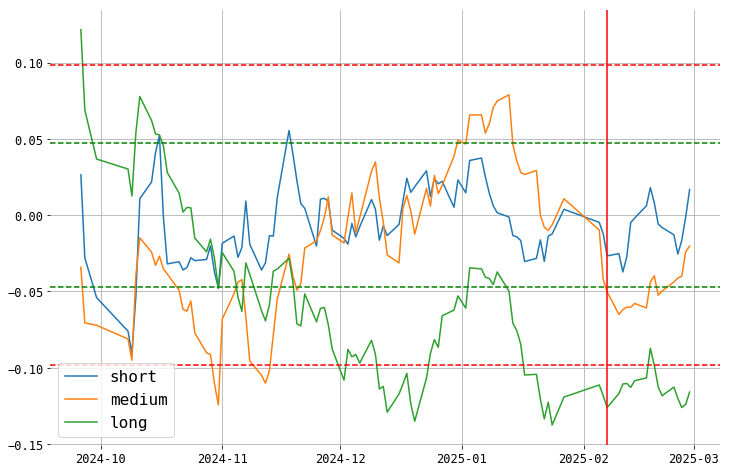

In [419]:
# 画出最后一段时间的线
plt.plot(Spread_pd.index[-100:],Spread_pd['yield_spread_short'][-100:] )
plt.plot(Spread_pd.index[-100:],Spread_pd['yield_spread_medium'][-100:] )
plt.plot(Spread_pd.index[-100:],Spread_pd['yield_spread_long'][-100:] )


# 画出长期均线
plt.axhline(Spread_pd['yield_spread_long'].std(), color='red', linestyle='--')
plt.axhline(-Spread_pd['yield_spread_long'].std(), color='red', linestyle='--')


# 画出中期均线
plt.axhline(Spread_pd['yield_spread_medium'].std(), color='green', linestyle='--')
plt.axhline(-Spread_pd['yield_spread_medium'].std(), color='green', linestyle='--')


plt.legend(['short', 'medium','long']);

# 画竖轴辅助线
# 开始投资的日期
plt.axvline(x=target_date, color='r', linestyle='-')


# 小结
1. 结合图形的形状
2. 考虑过去的情况
3. 考虑周期的情况
4. 分层进行仓位管理